In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pyBigWig
import pysam
from tqdm import tqdm
from scipy import stats

In [2]:
with open('PTA_names.txt', 'r') as fin:
    PTA_names = [line.strip() for line in fin if line.strip() != 'SRR8438299']
with open('LIANTI_names.txt', 'r') as fin:
    LIANTI_names = [line.strip() for line in fin]
    
names = PTA_names + LIANTI_names

In [4]:
pal = {
    'PTA': '#5AAA46',
    'MDA': '#F2B342',
    'LIANTI': '#C03830',
    'MALBAC': '#C43E96',
    'Bulk': '#825CA6',
    'CapWGS': '#317EC2'
}

In [5]:
meta_1 = pd.read_csv('PTA_meta.tsv', sep='\t', index_col='SRA_Run')
meta_1=meta_1[meta_1['amplification_method'].isin(['PTA','SCMDA'])]
def rename(row):
    if row.amplification_method=='SCMDA':
        return 'MDA' 
    else:
        return row.amplification_method
meta_1['amplification_method'] = meta_1.apply(rename, axis=1)
meta_1['study']='Gonzalez-Pena'
meta_1=meta_1[['study','amplification_method']]
# meta_1

In [6]:
meta_2 = pd.read_csv('LIANTI_meta.tsv', sep='\t', index_col='SRA_Run')
meta_2['study'] = 'Chen'

def amp(row):
    if 'LIANTI' in row.replicate:
        return 'LIANTI' 
    elif 'MDA' in row.replicate:
        return 'MDA' 
    elif 'MALBAC' in row.replicate:
        return 'MALBAC'
    elif 'Bulk' in row.replicate:
        return 'Bulk'
    
meta_2['amplification_method'] = meta_2.apply(amp, axis=1)
meta_2 = meta_2[meta_2['amplification_method'].isin(['LIANTI','MDA','MALBAC','Bulk'])]
meta_2 = meta_2[['study','amplification_method']]
# meta_2

In [14]:
meta = pd.concat([meta_1, meta_2])
# meta

In [15]:
coverages = {name : pd.read_csv(f"binned_coverage/{name}.csv", header=None)[0].to_list() for name in names}
coverages = pd.DataFrame(data=coverages)

In [16]:
lorenz_curves = {}
ginis = []
for name in meta.index:
    prop = coverages[name] / coverages[name].sum()
    # prop = prop[prop>0] 
    y = np.cumsum(prop.sort_values())
    x = np.arange(len(prop))
    x = x / len(x)
    x = np.concatenate(([0], x))
    y = np.concatenate(([0], y))
    lorenz_curves[name] = y
    auc = np.trapezoid(y, x)
    gini = 1 - 2 * auc
    ginis.append(gini)
    
meta['gini'] = ginis

common_x = np.linspace(0, 1, 100)

for name,arr in lorenz_curves.items():
    # Original x scale for the array (0 to 1, evenly spaced)
    original_x = np.linspace(0, 1, len(arr))
    # Interpolate to the common scale
    rescaled_y = np.interp(common_x, original_x, arr)
    lorenz_curves[name]=rescaled_y

lorenz_curves = pd.DataFrame(data=lorenz_curves, index=common_x)

/loc/scratch/35488560/ipykernel_32326/1237564992.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification_method", y="gini",


Text(0, 0.5, 'Gini Coefficient')

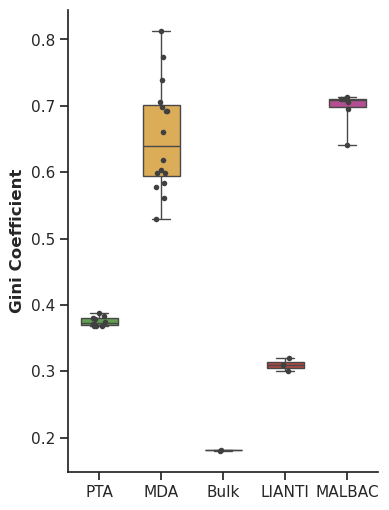

In [17]:
# sns.set_theme(style="ticks", palette="pastel")
fig,ax = plt.subplots(1,1,figsize=(4,6))
sns.boxplot(data=meta, x="amplification_method", y="gini",
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification_method", y="gini",
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
# plt.ylim(0.175,0.4)
plt.ylabel('Gini Coefficient', fontdict={'weight':'bold'})

In [18]:
test = coverages['SRR8438251']/coverages['SRR8438251'].sum()
print(test.shape)
test[test>0]

(3088282,)


10         3.238868e-08
11         1.797049e-07
12         1.003004e-07
13         1.410475e-07
14         1.577642e-07
               ...     
3088267    4.315008e-07
3088268    9.915115e-07
3088269    3.844850e-07
3088270    9.403165e-08
3088271    7.313573e-08
Name: SRR8438251, Length: 2904537, dtype: float64

Text(0, 0.5, 'Cumulative Fraction of Total Reads')

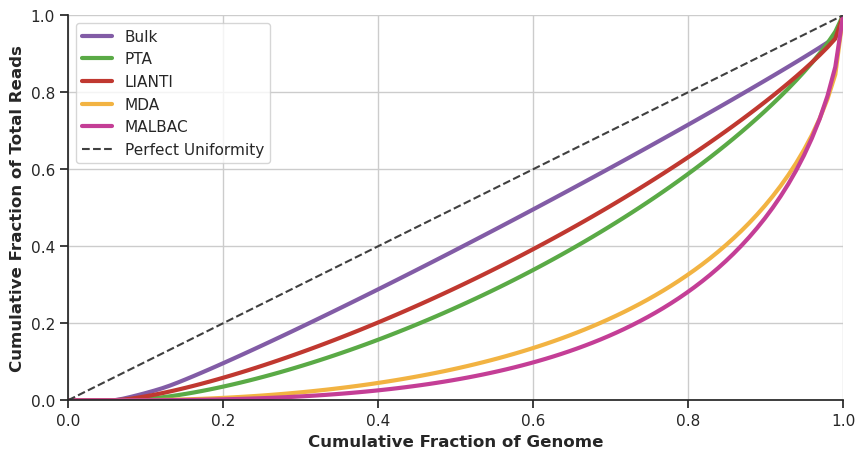

In [19]:
# Calculate mean and standard deviation of Lorenz curves for each group
mean_curves = {}
std_curves = {}
for group in meta['amplification_method'].unique():
    subset = lorenz_curves[meta[meta['amplification_method']==group].index]  # Select Lorenz curves for the group
    mean_curves[group] = subset.mean(axis=1)  # Mean across barcodes
    std_curves[group] = subset.std(axis=1)    # Standard deviation across barcodes

# Convert to DataFrame for plotting
mean_df = pd.DataFrame(mean_curves)
std_df = pd.DataFrame(std_curves)

plt.figure(figsize=(10, 5))
plt.plot(common_x, mean_df['Bulk'], label='Bulk', color=pal['Bulk'], linewidth=3)
plt.plot(common_x, mean_df['PTA'], label='PTA', color=pal['PTA'], linewidth=3)
plt.plot(common_x, mean_df['LIANTI'], label='LIANTI', color=pal['LIANTI'], linewidth=3)
plt.plot(common_x, mean_df['MDA'], label='MDA', color=pal['MDA'], linewidth=3)
plt.plot(common_x, mean_df['MALBAC'], label='MALBAC', color=pal['MALBAC'], linewidth=3)
plt.grid(True)
plt.plot([0,1],[0,1], color='.25', linestyle='--', label='Perfect Uniformity')
plt.legend(title='')
sns.despine()
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('Cumulative Fraction of Genome', fontdict={'weight':'bold'})
plt.ylabel('Cumulative Fraction of Total Reads', fontdict={'weight':'bold'})